<a href="https://colab.research.google.com/github/remijul/tutorial/blob/master/Dev_IA_Challenge_ML_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge ML

**Bienvenue dans le challenge ML !** Il s'agit d'évaluer les compétences acquises pour développer un modèle de Machine Learning.

Vous allez développer un classifieur automatique de Spam grâce à une collection existante de SMS labellisés (Spam / Ham). Ce dataset provient de [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).  
Pour ce challenge, voici les étapes sur lesquelles vous serez particulièrement évalué :
- Preprocessing
- Automatisation du process avec un pipeline
- Entrainement et validation croisée des modèles
- Recherche des hyper-paramètres
- Comparaison de différents modèles de classification
- Sélection d'une métrique d'erreur convenablement choisie vis-à-vis du contexte
- Sélection d'un modèle de classification et justification du choix  

Et en bonus :
- Compréhension et analyses des erreurs du modèle
- Compréhension et analyses des caractéristiques (features) d'intérêt
  
**Consignes :**
- Faites une copie de ce notebook et modifiez-le librement.
- Structuer votre notebook afin d'en faire un véritable rapport :
  - Titres, zones de texte et zones de code.
  - Il est important d'apporter des explications et des justifications pour les choix réalisés.
- En fin de challenge, partagez votre travail sur Simplonline (veuillez vous assurer que les accès à votre document sont autorisés à des tiers).

#1.Chargement des librairies

In [2]:
# Data
import pandas as pd
import numpy as np

# Graphics
import seaborn as sns ; sns.set()

# Machine learning - Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine learning - Automatisation
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Machine learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Machine learning - Model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine learning - Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, recall_score, fbeta_score, make_scorer

#2.Chargement de la collection de SMS

In [3]:
url = "https://raw.githubusercontent.com/remijul/dataset/master/SMSSpamCollection"
df = pd.read_csv(url, sep="\t", header=0, names=['label', 'message'])
df.head()

,label,message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


#3.Inspection des données

Informations générales sur le jeu de données

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5571 non-null   object
 1   message  5571 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Présence de données manquantes ?

In [ ]:
df.isna().sum()

label      0
message    0
dtype: int64

Répartition des labels Spam / Ham

In [ ]:
df['label'].value_counts(normalize=True)

ham     0.865913
spam    0.134087
Name: label, dtype: float64

**Info :** il sera nécessaire de respecter ces proportions dans l'étape de train-test-split.

Longueur des messages

In [ ]:
df['message'].str.len().describe()

count    5571.000000
mean       80.484473
std        59.946894
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: message, dtype: float64

#4.Preprocessing des messages

##4.1 Vectorisation
Cette méthode consiste à convertir la collection de messages en une matrice de comptage des tokens (i.e. mots ou caractères du corpus).  
Cette implémentation produit une représentation creuse (sparse) des comptages à l'aide de scipy.sparse.csr_matrix.  
Dans cette méthode un certain nombre d'éléments sont paramétrables, comme par exemple :
- `stop_words`,
- `ngram_range`,
- `max_df`,
- `max_features`,
- etc.  

Plus d'infos sur sklearn [CountVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#).

In [ ]:
# Explication sur les 3 premiers messages
vectorizer = CountVectorizer()
test_count_vect = vectorizer.fit_transform(df['message'][0:3])

print("Messages :", df['message'][0:3])
print("\nFeatures :", vectorizer.get_feature_names_out())
print("\nMatrix :", test_count_vect.toarray())

Messages : 0                        Ok lar... Joking wif u oni...
1    Free entry in 2 a wkly comp to win FA Cup fina...
2    U dun say so early hor... U c already then say...
Name: message, dtype: object

Features : ['08452810075over18' '2005' '21st' '87121' 'already' 'apply' 'comp' 'cup'
 'dun' 'early' 'entry' 'fa' 'final' 'free' 'hor' 'in' 'joking' 'lar' 'may'
 'ok' 'oni' 'question' 'rate' 'receive' 'say' 'so' 'std' 'text' 'then'
 'tkts' 'to' 'txt' 'wif' 'win' 'wkly']

Matrix : [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 1 1 1 0 1 1 1 0 0 2 2 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 3 1 0 1 1]
 [0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 1 0 0 1 0 0 0 0 0 0]]


##4.2 Transformation et vectorisation TF-IDF
Le TF-IDF (de l'anglais term frequency-inverse document frequency) est une méthode de pondération souvent utilisée en recherche d'information et en particulier dans la fouille de textes ([Wikipedia](https://fr.wikipedia.org/wiki/TF-IDF)).  

La méthode de sklearn `TfidfVectorizer()` consiste à convertir une collection de messagess en une matrice TF-IDF. Cette méthode est équivalente à `CountVectorizer()` suivi de `TfidfTransformer()`.  

Dans cette méthode un certain nombre d'éléments sont paramétrables, comme par exemple :
- `stop_words`,
- `ngram_range`,
- `max_df`,
- `max_features`,
- etc.  

Plus d'infos sur sklearn [TfidfVectorizer()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#).


In [ ]:
# Explication sur les 3 premiers messages
vectorizer = TfidfVectorizer()
test_count_vect = vectorizer.fit_transform(df['message'])#[0:3])

print("Messages :", df['message'][0:3])
print("\nFeatures :", vectorizer.get_feature_names_out().shape)
print("\nMatrix :", test_count_vect.toarray().shape)

Messages : 0                        Ok lar... Joking wif u oni...
1    Free entry in 2 a wkly comp to win FA Cup fina...
2    U dun say so early hor... U c already then say...
Name: message, dtype: object

Features : (8711,)

Matrix : (5571, 8711)


#5.Partition `train-test-split`

Dans la description des données, nous avons remarqué que la variable cible "Spam / Ham" était déséquilibrée.  
Nous devons donc adapter le train-test-split en conséquence en spécifiant le paramètre `stratify`.

In [9]:
y = df['label']
X = df['message']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f'Taille de X_rain {X_train.shape} et y_train {y_train.shape}')
print(f'Taille de X test {X_test.shape} et y_test {y_test.shape}')

Taille de X_rain (4178,) et y_train (4178,)
Taille de X test (1393,) et y_test (1393,)


Vérifions que la méthode de stratification a bien fonctionné.

In [ ]:
print(f'Répartition of `Spam/Ham` dans y_train :\n{y_train.value_counts(normalize=True)}')
print(f'Répartition of `Spam/Ham` dans y_test :\n{y_test.value_counts(normalize=True)}')

Répartition of `Spam/Ham` dans y_train :
ham     0.865965
spam    0.134035
Name: label, dtype: float64
Répartition of `Spam/Ham` dans y_test :
ham     0.865757
spam    0.134243
Name: label, dtype: float64


#6.Création du pipeline
Il s'agit ici de construire le pipeline qui comportera 2 étapes essentielles dans ce projet :
- le **preprocessing**, en appliquant la méthode de vectorisation, de transformation TF-IDF, ainsi qu'en ajustant les paramètres de ces méthodes.
- la **modélisation**, avec un algorithme de classification de type bayésien par exemple.

Pour des utilisations ultérieures, nous pouvons préparer une fonction dédiée à la construction de pipeline.

In [4]:
# Fonction pipeline
def pipe_spam(vectorizer=CountVectorizer(), classifier=MultinomialNB()):

  pipe = Pipeline(steps=[
       ('vect', vectorizer),
       ('clf', classifier)
       ])

  return(pipe)

In [ ]:
# Test du pipeline
pipe = pipe_spam(vectorizer=CountVectorizer(), classifier=MultinomialNB()).fit(X_train, y_train)
pipe

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

#7.Choix de la métrique d'erreur

##7.1.Recall
La performance des modèles sera évaluée à travers le `recall_score`.  
Il s'agit du taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés.  
C’est la capacité de notre modèle à détecter toutes les alertes, ce qui correspond bien au besoin du projet : développer un classifieur qui détecte les Spam avec la plus grande performance ([voir la documentation sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)).

In [ ]:
y_pred = pipe.predict(X_test)

recall_score(y_test, y_pred, pos_label='spam')

0.9090909090909091

##7.2.F1-score
Une métrique complémentaire sera utilisée, le `F1-score` qui et peut être interprété comme une moyenne harmonique de la précision et du rappel ([voir la documentation sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)).

In [ ]:
f1_score(y_test, y_pred, pos_label='spam')

0.9366391184573003

##7.3.Matrice de confusion
La distribution des prédictions vraies et fausses est résumée par la `confusion_matrix` [voir la documentation de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

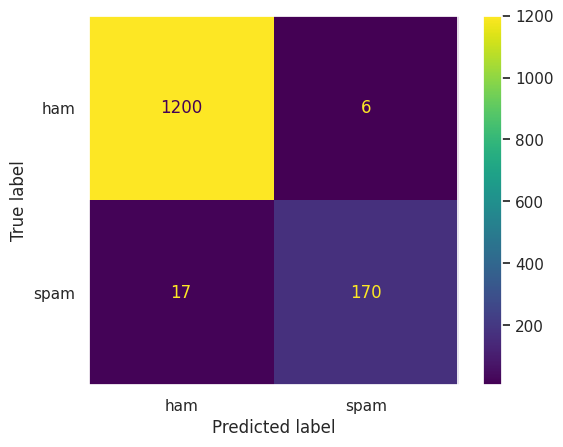

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.set_style("dark")
cm_plot = ConfusionMatrixDisplay(conf_matrix,
                                display_labels=df['label'].unique())

cm_plot.plot()

##7.4 Fonction de scoring sur les données de test

In [5]:
def scoring_model(fitted_estimator, y_test, X_test, pos_label='spam'):
  # Prediction
  y_pred = fitted_estimator.predict(X_test)

  # Recall
  recall = recall_score(y_true=y_test, y_pred=y_pred, pos_label=pos_label, average="weighted")

  # F1-score
  f1 = f1_score(y_true=y_test, y_pred=y_pred, pos_label=pos_label, average="weighted")

  # Confusion matrix
  conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

  return({'prediction': y_pred,
          'recall_score': recall.round(4),
          'conf_matrix': conf_matrix,
          'f1_score': f1.round(4)
   })

#8.Validation croisée & Recherche des hyper-paramètres
La validation croisée et le réglage des hyper-paramètres sont gérés avec une stratégie de recherche exhaustive `GridSearchCV()`.  
Plus d'informations pour [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [7]:
def crossval_paramsearch(X_train, y_train, estimator, parameters, cv=5):
  # Scoring
  multi_scoring = {"Recall": make_scorer(recall_score, pos_label="spam", average="weighted"),
                   "F1-score": make_scorer(f1_score, pos_label="spam", average="weighted")}

  # Grid search
  grid = GridSearchCV(estimator=estimator, param_grid=parameters,
                      scoring=multi_scoring, refit="Recall",
                      cv=cv, n_jobs=-1, verbose=0, error_score="raise")

  # Fit
  grid.fit(X_train, y_train)

  # Scores and results
  best_score = grid.best_score_.round(4)
  best_params = grid.best_params_
  training_time = grid.cv_results_['mean_fit_time'].mean().round(4)

  # Output
  return({
      'best_score': best_score,
      'best_params': best_params,
      'training_time': training_time,
      'fitted_model': grid.best_estimator_
  })

In [10]:
# Model and its parameters
#clf = GaussianNB()
parameters = [{
        'vect': [CountVectorizer(), TfidfVectorizer()],
        #'vect__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4)],
        #'vect__max_features': [500, 1000, 3000, 5000, 8000, None],
        #'clf__force_alpha' : [True, False]
        }]

crossval_paramsearch(X_train=X_train,
                     y_train=y_train,
                     estimator=pipe_spam(vectorizer=CountVectorizer(), classifier=MultinomialNB()),
                     parameters=parameters,
                     cv=5)

{'best_score': 0.9844,
 'best_params': {'vect': CountVectorizer()},
 'training_time': 0.2198,
 'fitted_model': Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])}

#9.Comparaison de modèles
Nous allons maintenant utiliser la fonction précédente sur plusieurs modèles de classification et ainsi comparer leurs performances

##9.1 Fonction de comparaison
Pour faciliter le processus de comparaison des modèles, nous pouvons créer une fonction dédiée `getClassifResults()`, basée sur les précédentes :
- fonction `crossval_paramsearch()` pour la validation croisée et le réglage des hyper-paramètres
- fonction `scoring_model()` pour la prédiction et la notation.
  
Cette fonction globale doit être flexible et adaptable à un ensemble de paramètres d'entrée :
- `data` : l'ensemble de données à des fins de classification
- `estimator` : le pipeline comprenant à la fois le modèle de prétraitement et de classification
- `parameters` : une grille d'hyper-paramètres pour la recherche de grille
- `scoring` : la métrique utilisée pour l'évaluation
- `cv` : le nombre de sous ensembles pour la validation croisée, `5` est la valeur par défaut.

In [11]:
def getClassifResults(data, estimator, parameters, scoring='recall', cv=5):

  # Prepare data
  y = df['label']
  X = df['message']

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

  # Cross Validation & Hyper-Paramaters tuning
  fitted_estimator = crossval_paramsearch(X_train=X_train, y_train=y_train, estimator=estimator,
                     parameters=parameters, cv=cv)

  # Prediction and scoring
  test_score = scoring_model(fitted_estimator=fitted_estimator['fitted_model'], y_test=y_test, X_test=X_test)

  return({'fitted_model': fitted_estimator,
          'test_score': test_score})

##9.2 Multinomial Naive Bayes
Le classifieur multinomial Naive Bayes convient à la classification avec des caractéristiques discrètes (par exemple, le nombre de mots pour la classification de texte).  
La distribution multinomiale nécessite normalement un nombre entier de caractéristiques. Cependant, en pratique, les comptages fractionnaires tels que tf-idf peuvent également fonctionner.  
Voir la documentation [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

In [12]:
# Model and its parameters
estimator = pipe_spam(vectorizer=CountVectorizer(), classifier=MultinomialNB())

parameters = [
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__stop_words' : [None, 'english'],
        'vect__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4)],
        'vect__max_features': [500, 1000, 3000, 5000, 8000, None],
        'clf__force_alpha' : [True, False]
    }
]

# Results
MNB_results = getClassifResults(data=df, estimator=estimator, parameters=parameters)

print(f"Training time (sec): {MNB_results['fitted_model']['training_time']} ")
print(f"Training score (Recall): {MNB_results['fitted_model']['best_score']} ")
print(f"Test score (Recall): {MNB_results['test_score']['recall_score']} ")
print(f"Best model: {MNB_results['fitted_model']['best_params']} ")


Training time (sec): 0.4328 
Training score (Recall): 0.9868 
Test score (Recall): 0.9871 
Best model: {'clf__force_alpha': True, 'vect': CountVectorizer(ngram_range=(1, 2), stop_words='english'), 'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'} 


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'spam') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'spam') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


##9.3 Random Forest Classifier
Random Forest Classifier as described in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [ ]:
# Model and its parameters
estimator = pipe_spam(vectorizer=CountVectorizer(), classifier=RandomForestClassifier())

parameters = [
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4)],
        'vect__max_features': [500, 1000, 3000, 5000, 8000, None],
        'clf__n_estimators' : range(50, 151, 50),
        #'clf__criterion' : ('gini', 'entropy'),
        #'clf__max_depth' : range(3, 11, 2),
        #'clf__min_samples_split' : range(3, 11, 2),
        #'clf__min_samples_leaf' : range(1, 21, 2)
    }
]

# Results
RF_results = getClassifResults(data=df, estimator=estimator, parameters=parameters)

print(f"Training time (sec): {RF_results['fitted_model']['training_time']} ")
print(f"Training score (Recall): {RF_results['fitted_model']['best_score']} ")
print(f"Test score (Recall): {RF_results['test_score']['recall_score']} ")
print(f"Best model: {RF_results['fitted_model']['best_params']} ")

Training time (sec): 2.2193 
Training score (Recall): 0.8786 
Test score (Recall): 0.861 
Best model: {'clf__n_estimators': 150, 'vect': CountVectorizer(max_features=500, ngram_range=(1, 2)), 'vect__max_features': 500, 'vect__ngram_range': (1, 2)} 


##9.4 Gradient Boosting Classifier
Gradient Boosting Classifier as described in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [ ]:
# Model and its parameters
estimator = pipe_spam(classifier=RandomForestClassifier())

parameters = [
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4)],
        'vect__max_features': [500, 1000, 3000, 5000, 8000, None],
        'clf__n_estimators' : range(50, 151, 50),
        'clf__max_depth' : range(3, 8, 2),
        #'clf__criterion' : ('gini', 'entropy'),
        #'clf__max_depth' : range(3, 11, 2),
        #'clf__min_samples_split' : range(3, 11, 2),
        #'clf__min_samples_leaf' : range(1, 21, 2)
    }
]

# Results
GB_results = getClassifResults(data=df, estimator=estimator, parameters=parameters)

print(f"Training time (sec): {GB_results['fitted_model']['training_time']} ")
print(f"Training score (Recall): {GB_results['fitted_model']['best_score']} ")
print(f"Test score (Recall): {GB_results['test_score']['recall_score']} ")
print(f"Best model: {GB_results['fitted_model']['best_params']} ")

Training time (sec): 0.9445 
Training score (Recall): 0.5089 
Test score (Recall): 0.4973 
Best model: {'clf__max_depth': 7, 'clf__n_estimators': 100, 'vect': TfidfVectorizer(max_features=500, ngram_range=(1, 3)), 'vect__max_features': 500, 'vect__ngram_range': (1, 3)} 


##9.5 Support Vector Machine for Classification
Support Vector Classifier as described in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#).

In [ ]:
# Model and its parameters
estimator = pipe_spam(classifier=SVC())

parameters = [
    {
        'vect': [CountVectorizer(), TfidfVectorizer()],
        'vect__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4)],
        'vect__max_features': [500, 1000, 3000, 5000, 8000, None],
        'clf__kernel': ('linear', 'rbf'),
        'clf__C' : [1, 3, 5, 7, 9]
    }
]

# Results
SVM_results = getClassifResults(data=df, estimator=estimator, parameters=parameters)

print(f"Training time (sec): {SVM_results['fitted_model']['training_time']} ")
print(f"Training score (Recall): {SVM_results['fitted_model']['best_score']} ")
print(f"Test score (Recall): {SVM_results['test_score']['recall_score']} ")
print(f"Best model: {SVM_results['fitted_model']['best_params']} ")

Training time (sec): 1.7123 
Training score (Recall): 0.9375 
Test score (Recall): 0.9305 
Best model: {'clf__C': 3, 'clf__kernel': 'linear', 'vect': TfidfVectorizer(ngram_range=(1, 4)), 'vect__max_features': None, 'vect__ngram_range': (1, 4)} 


##9.6 Sélection de modèle
À partir des modèles précédents et des performances obtenues, nous retiendrons le `MultinomialNB()` pour à la fois sa rapidité, sa performance et son interprétabilité.

#10 Analyse des erreurs du modèle
Il s'agit ici de se focaliser sur les messages qui ont été mal classés :
- les messages Ham détectés comme des Spam, erreur de type 1
- les messages Spam détectés comme des Ham, erreur de type 2

##10.1 Messages Ham détectés Spam

##10.2 Messages Spam détectés Ham

###10.2.1 Extraction des messages

In [13]:
# Etape 1 : récupération des données de test et de prediction
y_pred = MNB_results['test_score']['prediction']
print(y_pred)
print(y_test)

['ham' 'spam' 'ham' ... 'spam' 'ham' 'ham']
4942     ham
3063    spam
2325     ham
4259     ham
2067     ham
        ... 
2412    spam
2389     ham
1224    spam
4827     ham
1481     ham
Name: label, Length: 1393, dtype: object


In [14]:
# Etape 2 : test selon conditions pour erreur de type 2
print(list(y_test == 'spam'))
print(list(y_pred == 'ham'))


[False, True, False, False, False, False, False, False, True, False, False, False, True, False, False, True, True, False, False, False, False, True, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False,

In [15]:
# Etape 3 : fonction de test de correspondance et d'extraction
def compareList(test, pred, label):
    # Booléen - Liste des messages réels correspondant à 'label' (spam/ham)
    list_test = list(test == label)

    # Booléen - Liste des messages prédits correspondant à 'label' (spam/ham)
    list_pred = list(pred != label)

    # Test des 2 listes de booléens quand égalité
    return [i==j for i, j in zip(list_test, list_pred)]

print(compareList(test=y_test, pred=y_pred, label='spam'))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, F

In [19]:
# Etape 4 : récupération des messages pour les erreurs de type 2
erreur_type2 = compareList(test=y_test, pred=y_pred, label='spam')
msg_erreur_type2 = X_test[erreur_type2]

print(msg_erreur_type2)

3359    Sorry I missed your call let's talk when you h...
750     Do you realize that in about 40 years, we'll h...
2822    ROMCAPspam Everyone around should be respondin...
3414                              No pic. Please re-send.
3889                    Unlimited texts. Limited minutes.
3980                                   ringtoneking 84484
2246    Hi ya babe x u 4goten bout me?' scammers getti...
395     From here after The performance award is calcu...
1939    More people are dogging in your area now. Call...
1662    Hi if ur lookin 4 saucy daytime fun wiv busty ...
1268    Can U get 2 phone NOW? I wanna chat 2 set up m...
5539    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
3301             RCT' THNQ Adrian for U text. Rgds Vatian
4701                               I liked the new mobile
1637    0A$NETWORKS allow companies to bill for SMS, s...
1429    For sale - arsenal dartboard. Good condition b...
730     Email AlertFrom: Jeri StewartSize: 2KBSubject:...
4599          

### 10.2.2 Investigations
A partir de maintenant plusieurs pistes sont à investiguer afin d'évaluer si les facteurs suivants sont potentiellement responsables d'une mauvaise détection :
- longueur des messages
- présence de chiffres, caractèes spéciaux
- vocabulaire
- etc.

Bien sûr une bonne compréhension du modèle permettra de rendre cette investigation plus efficace !

#11 Feature importance

##11.1 Modèle final

In [20]:
# Prepare data
y = df['label']
X = df['message']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Model and its parameters
best_estimator = pipe_spam(
    vectorizer=CountVectorizer(max_features=1000, ngram_range=(1, 1), stop_words=None),
    classifier=MultinomialNB(force_alpha=True))

# Fit
best_estimator.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_features=1000)),
                ('clf', MultinomialNB(force_alpha=True))])

##11.2 Features retenues pour l'apprentissage

In [22]:
# Vérification de la tailles des différents objets
print(len(best_estimator.named_steps['clf'].feature_log_prob_[0]))
print(best_estimator.named_steps['clf'].n_features_in_)#feature_names_in_
print(len(best_estimator.named_steps['vect'].vocabulary_))

1000
1000
1000


In [23]:
# Features retenues après vectorisation
best_estimator.named_steps['vect'].vocabulary_

{'when': 941,
 'you': 995,
 'just': 446,
 'put': 683,
 'in': 431,
 'the': 826,
 'choose': 169,
 'my': 565,
 'number': 596,
 'and': 68,
 'will': 953,
 'show': 753,
 'right': 706,
 '20': 19,
 'that': 824,
 'call': 140,
 'cost': 199,
 'which': 944,
 'guess': 368,
 'bad': 102,
 'miss': 535,
 'ya': 986,
 'need': 570,
 'want': 918,
 'love': 495,
 'going': 354,
 'to': 853,
 'fr': 318,
 'home': 410,
 'ok': 605,
 'can': 149,
 'so': 773,
 'am': 65,
 'how': 416,
 'much': 560,
 'for': 312,
 'an': 67,
 'dont': 247,
 'think': 835,
 'card': 152,
 'uk': 884,
 'ask': 84,
 'someone': 775,
 'has': 384,
 'gone': 355,
 'before': 111,
 'if': 425,
 'do': 239,
 'its': 440,
 'lt': 498,
 'gt': 365,
 'did': 231,
 'already': 61,
 'lar': 458,
 'at': 88,
 'are': 79,
 'write': 979,
 'this': 839,
 'week': 929,
 'im': 428,
 'good': 357,
 'have': 386,
 'been': 110,
 'thinking': 837,
 'about': 39,
 'some': 774,
 'eat': 265,
 'anything': 75,
 'frnd': 327,
 'not': 591,
 'juz': 447,
 'word': 968,
 'says': 727,
 'be': 106,


##11.3 Importance - Probabilité empirique

In [24]:
# Probabilités
best_estimator.named_steps['clf'].feature_log_prob_

array([[-10.58007335, -10.58007335, -10.58007335, ...,  -8.50063181,
         -7.74686   ,  -7.14608614],
       [ -6.99539979,  -6.25346244,  -6.90008961, ...,  -6.90008961,
         -9.29798488,  -9.29798488]])

In [25]:
# Probabilités HAM
best_estimator.named_steps['clf'].feature_log_prob_[0]

array([-10.58007335, -10.58007335, -10.58007335, -10.58007335,
       -10.58007335, -10.58007335,  -7.94101602,  -9.88692617,
       -10.58007335, -10.58007335,  -8.78831388,  -8.97063543,
       -10.58007335, -10.58007335, -10.58007335, -10.58007335,
        -9.88692617, -10.58007335,  -8.38284877,  -8.97063543,
       -10.58007335,  -9.88692617, -10.58007335, -10.58007335,
       -10.58007335,  -8.27748825,  -8.27748825, -10.58007335,
        -8.97063543, -10.58007335, -10.58007335, -10.58007335,
       -10.58007335, -10.58007335, -10.58007335, -10.58007335,
       -10.58007335,  -8.38284877,  -7.68970159,  -5.70487602,
        -7.53555091, -10.58007335,  -8.38284877,  -7.68970159,
        -8.38284877,  -7.40201952,  -8.38284877,  -7.87202315,
        -7.80748463,  -6.48572879,  -7.58434107,  -6.62882963,
        -8.27748825,  -8.78831388, -10.58007335,  -8.01512399,
        -7.17887597,  -7.32197681,  -5.39268754,  -8.0951667 ,
        -8.27748825,  -6.39041861,  -7.63563437,  -6.64

In [26]:
# Probabilités SPAM
best_estimator.named_steps['clf'].feature_log_prob_[1]

array([-6.99539979, -6.25346244, -6.90008961, -6.81307823, -6.81307823,
       -6.65892755, -6.25346244, -5.77162436, -5.86399768, -6.30225261,
       -6.73303552, -7.35207473, -6.90008961, -6.65892755, -5.34674116,
       -6.03988834, -5.56031526, -5.68706697, -6.52539616, -7.35207473,
       -7.1007603 , -6.40761312, -6.90008961, -6.58993468, -6.90008961,
       -6.52539616, -8.6048377 , -6.73303552, -5.60910543, -5.68706697,
       -6.20694243, -6.58993468, -6.52539616, -6.65892755, -6.65892755,
       -6.90008961, -7.1007603 , -9.29798488, -9.29798488, -7.50622541,
       -9.29798488, -6.81307823, -9.29798488, -6.52539616, -9.29798488,
       -9.29798488, -9.29798488, -7.91169052, -9.29798488, -7.50622541,
       -9.29798488, -7.91169052, -9.29798488, -7.50622541, -7.1007603 ,
       -9.29798488, -9.29798488, -9.29798488, -6.11993105, -9.29798488,
       -7.91169052, -8.6048377 , -9.29798488, -8.19937259, -9.29798488,
       -6.90008961, -9.29798488, -6.3535459 , -4.78712538, -9.29

In [27]:
# DataFrame
df_importance = pd.DataFrame({
    'feature' : best_estimator.named_steps['vect'].vocabulary_.keys(),
    'importance_ham': np.exp(best_estimator.named_steps['clf'].feature_log_prob_[0, :]),
    'importance_spam': np.exp(best_estimator.named_steps['clf'].feature_log_prob_[1, :])
})

df_importance.head()

,feature,importance_ham,importance_spam
0,when,0.000025,0.000916
1,you,0.000025,0.001924
2,just,0.000025,0.001008
3,put,0.000025,0.001099
4,in,0.000025,0.001099


##11.4 Résultats

[Text(0.5, 1.0, 'Classe SPAM - Top 20 Features')]

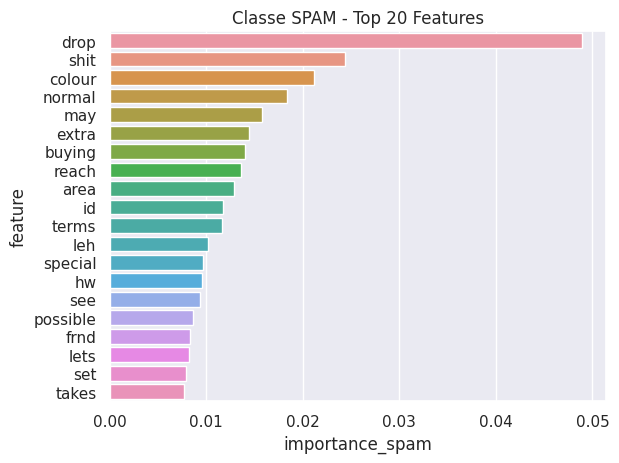

In [28]:
sns.barplot(data = df_importance.sort_values(by='importance_spam', ascending=False)[:20],
            x="importance_spam", y="feature").set(title='Classe SPAM - Top 20 Features')

Voici donc une sélection du vocabulaire qui conduit le classifieur à détecter des messages comme des Spam.

#12 Prochaines étapes
Dans une logique de perfectionnement du classifieur et de ce projet de manière générale, voici quelques idées de prochaines étapes :
-  Poursuivre l'analyse et la compréhesion des erreurs du modèle
-  Poursuivre l'analyse et la compréhesion des feature importances
- Améliorer les performances du modèle
- Tester ce modèle sur un nouveau dataset de SMS
- etc.

# Fin du challenge
Bravo ! Vous êtes arrivés sans peine jusqu'à la fin de ce challenge ML ✌ !